In [43]:
import numpy as np
import matplotlib.pyplot as plt 
import base64
import json
import random 

from ultralytics import YOLO
from ultralytics.DislocationMaskProcessing.get_length_box import get_endpoints as get_disdata
from ultralytics.DislocationMaskProcessing.labelme_json import labelme_json, labelme_shape
%matplotlib inline

In [2]:
# load the weights 
checkpoint_path = "../checkpoint/yolov8_large_weights.pt"

model = YOLO(checkpoint_path)

# start making predictions on TEM images. We just need to provide the path of the image. If you want to save the predictions, use save=True 

In [3]:
#example, you can put there entire folder, if you like

res=model.predict("../sample_images/sample1.jpg",
                  save=False, # change to True to save the predictions 
                  hide_labels=True,
                  conf=0.6,
                  iou=0.8,
                  line_thickness=1,
                  retina_masks=True,
                  agnostic_nms=True)

Ultralytics YOLOv8.0.49 🚀 Python-3.9.5 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients, 343.7 GFLOPs

image 1/1 /home/k.govind/Desktop/PhD_work/Publications/IEEE-Nano/2023_IEEE_Instance-Segmentation-of-Dislocations-in-TEM/sample_images/sample1.jpg: 640x640 6 pileup_0s, 41.5ms
Speed: 2.9ms preprocess, 41.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


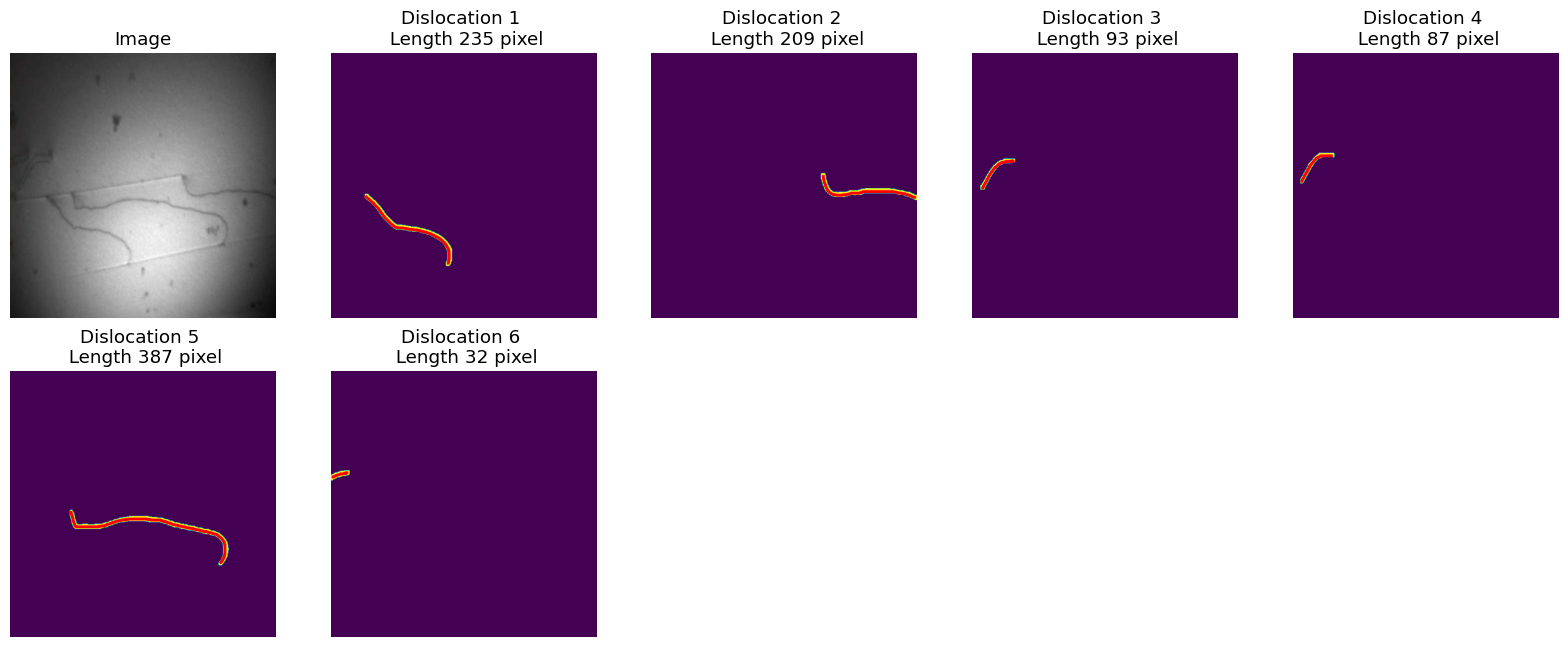

In [56]:
plt.figure(figsize=(20,20))
plt.subplot(5,5,1)
plt.imshow(res[0].orig_img)
plt.axis("off")
plt.title(f"Image")
spline_data = {}
for i in range(res[0].masks.shape[0]):
    mask = res[0].masks[i].cpu().numpy()
    xcoord , ycoord, length, _,_,_center = get_disdata(mask.data, 
                                                       area_limits=(50,50000),
                                                       show_bboxes=False)
    plt.subplot(5,5,2+i)
    plt.imshow(mask.data) # show image 
    plt.plot(xcoord[0],ycoord[0],lw=2.0,color="red") # plot extracted splines 
    spline_data.update({f"Dis_{i+1} ":[list(xcoord[0]),list(ycoord[0])]})
    plt.axis("off")
    plt.title(f"Dislocation {i+1} \n Length {length[0]:1.0f} pixel")

# Converting the predictions into readable file for labelme to be used for further corrections if required.  

This will provide you a json file similar to what you will get if you handlabel the image by yourself using labelme. Our method allow us to create this file using the predictions from yolo. This json file can be used to open the annotations in labelme which allow us to make any corrections in the corrections if needed. 

In [60]:
shapes = []
for i in range(res[0].masks.shape[0]):
    mask = res[0].masks[i].cpu().numpy()
    xcoord , ycoord, length, _,_,_center = get_disdata(mask.data, 
                                                       area_limits=(50,50000),
                                                       show_bboxes=False)
    xcoord,ycoord = xcoord[0],ycoord[0]
    shape = labelme_shape.copy()
    points = np.array([xcoord,ycoord]).transpose().tolist()
    shape["points"] = points
    if(len(points) >30): 
#         point_ids = sorted(random.sample(np.arange(0,len(points),1).tolist(),30))
        point_ids = np.linspace(0, len(points)-1, 30, dtype=int)
        new_points = []
        for idx in point_ids:
            new_points.append([xcoord[idx]*1.0,ycoord[idx]*1.0]) # fix to convert to json data. *1.0 
        shape["points"] = new_points 
    
    shapes.append(shape) 
    
imageHeight = mask.data.shape[0]
imageWidth = mask.data.shape[1]
imagePath = res[0].path 

with open(imagePath, "rb") as f:
    imageData = f.read()
    imageData = base64.b64encode(imageData).decode("utf-8")
        
labelme_json["imagePath"] = imagePath
labelme_json["imageHeight"] = imageHeight
labelme_json["imageWidth"] = imageWidth
labelme_json["imageData"] = imageData
labelme_json["shapes"] = shapes

jsonfile_path = imagePath.replace("jpg","json")
with open(jsonfile_path, 'w', encoding='utf-8') as f:
    json.dump(labelme_json, f, ensure_ascii=False, indent=2)
    
    
print(f"Json file is saved as {jsonfile_path}")

Json file is saved as /home/k.govind/Desktop/PhD_work/Publications/IEEE-Nano/2023_IEEE_Instance-Segmentation-of-Dislocations-in-TEM/sample_images/sample1.json
